In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import inspect

from deep_bsde_solvers import BSDEsolver_Milstein
from deep_bsde_solvers import BSDEsolver_Euler
from deep_bsde_solvers import fbsde

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Calculating analytic Y_0 solution for Example 1

a = 1
sigma = 1
b = 1
gam = np.sqrt(3)

real_y0 = (2*gam*np.exp((gam+1)/2)/(gam - 1 +(gam + 1)*np.exp(gam)))**2* \
            np.exp(2*(1-np.exp(gam))/(gam - 1 + (gam + 1)*np.exp(gam)))

Deep BSDE with Euler-Maruyama scheme plot 

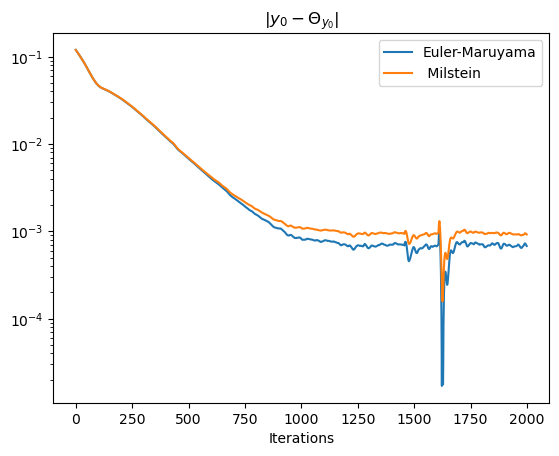

In [4]:
torch.manual_seed(1)
np.random.seed(1) 

dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 100, 2000, 1000

x_0, T = torch.ones(dim_x), 1

def b(t, x, y):
    return (1-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return torch.sqrt(torch.clamp(x, min=1e-12)).reshape(batch_size, dim_x, dim_d)

def dsigma(t, x):
    grad = 0.5 / torch.sqrt(torch.clamp(x, min=1e-12))
    return torch.diag_embed(grad)

def f(t, x, y, z):
    max_x, _ = x.max(dim=1, keepdim=True)
    return (-y*max_x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, dsigma, f, g, T,dim_x, dim_y, dim_d)

bsde_solver_e = BSDEsolver_Euler(equation, dim_h)
loss_data_e, y0_data_e = bsde_solver_e.train(batch_size, N, itr)

torch.manual_seed(1)
np.random.seed(1)
bsde_solver_m = BSDEsolver_Milstein(equation, dim_h)
loss_data_m, y0_data_m = bsde_solver_m.train(batch_size, N, itr)



plt.figure()
plt.semilogy(np.abs(y0_data_e - real_y0))
plt.semilogy(np.abs(y0_data_m - real_y0))
plt.xlabel('Iterations')
plt.title('$|y_0 - \Theta_{y_0}|$')
plt.legend(['Euler-Maruyama', ' Milstein'])

Deep BSDE with Milstein scheme plot

Figure 4.2 Table code

In [7]:
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 100, 1000, 1000

x_0, T = torch.ones(dim_x), 1

def b(t, x, y):
    return (1-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return torch.sqrt(torch.clamp(x, min=1e-12)).reshape(batch_size, dim_x, dim_d)

def dsigma(t, x):
    grad = 0.5 / torch.sqrt(torch.clamp(x, min=1e-12))
    return torch.diag_embed(grad)

def f(t, x, y, z):
    max_x, _ = x.max(dim=1, keepdim=True)
    return (-y*max_x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, dsigma, f, g, T,dim_x, dim_y, dim_d)

errs_mil   = []
errs_euler = []
loss_mil = []
loss_euler = []
for seed in range(3):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    bsde_m = BSDEsolver_Milstein(equation, dim_h)
    bsde_e = BSDEsolver_Euler(equation, dim_h)

    loss_m, y0_m = bsde_m.train(batch_size, N, itr)
    loss_e, y0_e = bsde_e.train(batch_size, N, itr)

    err_m_500   = np.abs(real_y0 - y0_m[500])
    err_m_final = np.abs(real_y0 - y0_m[-1])
    err_e_500   = np.abs(real_y0 - y0_e[500])
    err_e_final = np.abs(real_y0 - y0_e[-1])

    loss_m_500 = loss_m[500]
    loss_m_final = loss_m[-1]
    loss_e_500 = loss_e[500]
    loss_e_final = loss_e[-1]
    
    errs_mil.append([err_m_500,   err_m_final])
    errs_euler.append([err_e_500,   err_e_final])
    loss_mil.append([loss_m_500, loss_m_final])
    loss_euler.append([loss_e_500, loss_e_final])
    

errs_mil   = np.array(errs_mil)
errs_euler = np.array(errs_euler)

loss_mil = np.array(loss_mil)
loss_euler = np.array(loss_euler)

err_mil_mean = errs_mil.mean(axis=0)      
err_mil_sd   = errs_mil.std(axis=0, ddof=1)

err_eul_mean = errs_euler.mean(axis=0)
err_eul_sd    = errs_euler.std(axis=0, ddof=1)

loss_mil_mean = loss_mil.mean(axis=0)
loss_mil_sd = loss_mil.std(axis=0, ddof=1)

loss_eul_mean = loss_euler.mean(axis=0)
loss_eul_sd = loss_euler.std(axis=0, ddof=1)

data = {
    "No. of iterations": [500, 1000],
    "Milstein Error of $Y_0$": [f'{mean:.8f} +- {sd:.8f}' for mean, sd in zip(err_mil_mean, err_mil_sd)],
    "E-M Error of $Y_0$": [f'{mean:.8f} +- {sd:.8f}' for mean, sd in zip(err_eul_mean, err_eul_sd)],
    "Milstein loss" :  [f'{mean:.8f} +- {sd:.8f}' for mean, sd in zip(loss_mil_mean, loss_mil_sd)],
    "E-M loss" : [f'{mean:.8f} +- {sd:.8f}' for mean, sd in zip(loss_eul_mean, loss_eul_sd)]
}

df = pd.DataFrame(data)
df

,No. of iterations,Milstein Error of $Y_0$,E-M Error of $Y_0$,Milstein loss,E-M loss
0,500,0.00269888 +- 0.00369645,0.13811124 +- 0.06192887,0.00082058 +- 0.00045197,0.15434084 +- 0.10470935
1,1000,0.00108226 +- 0.00001538,0.03297491 +- 0.02609184,0.00033772 +- 0.00022801,0.01440675 +- 0.01161303


Figure 4.3 Table code

In [8]:
dim_x, dim_y, dim_d, dim_h, itr, batch_size = 1, 1, 1, 11, 2000, 1000

x_0, T = torch.ones(dim_x), 1

def b(t, x, y):
    return (1-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return torch.sqrt(torch.clamp(x, min=1e-12)).reshape(batch_size, dim_x, dim_d)

def dsigma(t, x):
    grad = 0.5 / torch.sqrt(torch.clamp(x, min=1e-12))
    return torch.diag_embed(grad)

def f(t, x, y, z):
    max_x, _ = x.max(dim=1, keepdim=True)
    return (-y*max_x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, dsigma, f, g, T, dim_x, dim_y, dim_d)
table = []
for N in [25, 50, 100, 200]:
    errs_m = []
    errs_e = []
    loss_m = []
    loss_e = []
    
    for seed in range(6):
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        solver_m = BSDEsolver_Milstein(equation, dim_h)
        solver_e = BSDEsolver_Euler(equation, dim_h)
        
        lm, y0m = solver_m.train(batch_size, N, itr)
        le, y0e = solver_e.train(batch_size, N, itr)
        print(f"N={N}, seed={seed} → Loss_Mil={lm[-1]:.6f}, Loss_EM={le[-1]:.6f}")
        
        errs_m.append(np.abs(real_y0 - y0m[-1]))
        errs_e.append(np.abs(real_y0 - y0e[-1]))
        loss_m.append(lm[-1])
        loss_e.append(le[-1])
    
    errs_m = np.array(errs_m)
    errs_e = np.array(errs_e)
    loss_m = np.array(loss_m)
    loss_e = np.array(loss_e)
    
    err_m_mean, err_m_std = errs_m.mean(),   errs_m.std(ddof=1)
    err_e_mean, err_e_std = errs_e.mean(),   errs_e.std(ddof=1)
    loss_m_mean, loss_m_sd = loss_m.mean(), loss_m.std(ddof=1)
    loss_e_mean, loss_e_sd = loss_e.mean(), loss_e.std(ddof=1)
    
    table.append({
        "N": N,
        "Milstein Error of $Y_0$":     f"{err_m_mean:.8f} +- {err_m_std:.8f}",
        "E–M Error of $Y_0$":          f"{err_e_mean:.8f} +- {err_e_std:.8f}",
        "Milstein Loss":               f"{loss_m_mean:.8f} +- {loss_m_sd:.8f}",
        "E–M Loss":                    f"{loss_e_mean:.8f} +- {loss_e_sd:.8f}",
    })

df = pd.DataFrame(table)
df

N=25, seed=0 → Loss_Mil=0.000254, Loss_EM=0.000945
N=25, seed=1 → Loss_Mil=0.000431, Loss_EM=0.001569
N=25, seed=2 → Loss_Mil=0.000255, Loss_EM=0.005042
N=25, seed=3 → Loss_Mil=0.000504, Loss_EM=0.001224
N=25, seed=4 → Loss_Mil=0.000488, Loss_EM=0.001100
N=25, seed=5 → Loss_Mil=0.000488, Loss_EM=0.001595
N=50, seed=0 → Loss_Mil=0.000256, Loss_EM=0.000686
N=50, seed=1 → Loss_Mil=0.000349, Loss_EM=0.001189
N=50, seed=2 → Loss_Mil=0.000203, Loss_EM=0.005698
N=50, seed=3 → Loss_Mil=0.000422, Loss_EM=0.000849
N=50, seed=4 → Loss_Mil=0.000603, Loss_EM=0.000670
N=50, seed=5 → Loss_Mil=0.000787, Loss_EM=0.000633
N=100, seed=0 → Loss_Mil=0.000212, Loss_EM=0.000458
N=100, seed=1 → Loss_Mil=0.000233, Loss_EM=0.000849
N=100, seed=2 → Loss_Mil=0.000124, Loss_EM=0.004829
N=100, seed=3 → Loss_Mil=0.000375, Loss_EM=0.000718
N=100, seed=4 → Loss_Mil=0.000520, Loss_EM=0.000519
N=100, seed=5 → Loss_Mil=0.000551, Loss_EM=0.000415
N=200, seed=0 → Loss_Mil=0.000176, Loss_EM=0.000342
N=200, seed=1 → Loss_Mil

,N,Milstein Error of $Y_0$,E–M Error of $Y_0$,Milstein Loss,E–M Loss
0,25,0.00452279 +- 0.00021274,0.00311660 +- 0.00114596,0.00040331 +- 0.00011797,0.00191236 +- 0.00155433
1,50,0.00206135 +- 0.00027113,0.00158505 +- 0.00036421,0.00043657 +- 0.00022166,0.00162085 +- 0.00200805
2,100,0.00097303 +- 0.00019271,0.00143678 +- 0.00140773,0.00033592 +- 0.00017449,0.00129791 +- 0.00173757
3,200,0.00050499 +- 0.00019854,0.00081608 +- 0.00103583,0.00027932 +- 0.00014372,0.00128553 +- 0.00189037


Example 2 simulation

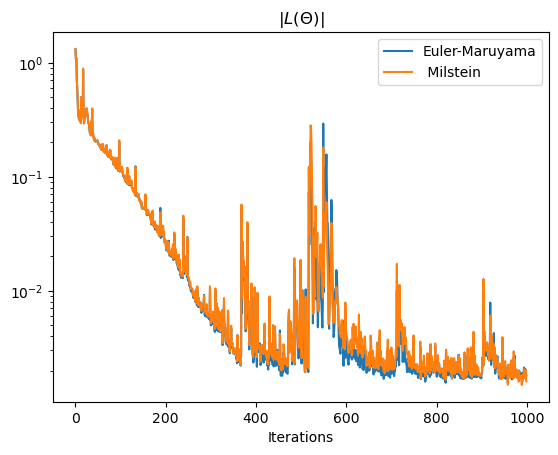

In [5]:
torch.manual_seed(0)
np.random.seed(0)

dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 30, 1, 1, 50, 100, 1000, 1000

x_0, T = torch.ones(dim_x), 1

a_i = torch.rand(dim_x).reshape(1, -1) * torch.ones((batch_size, dim_x))
b_i = torch.rand(dim_x).reshape(1, -1) * torch.ones((batch_size, dim_x))
sigma_i = torch.rand(dim_x).reshape(1, -1) * torch.ones((batch_size, dim_x))

def b(t, x, y):
    return a_i*(b_i-x).reshape(batch_size, dim_x)


def sigma(t, x):
    return sigma_i.unsqueeze(-1) * torch.sqrt(torch.clamp(x, min=1e-12)).reshape(batch_size, dim_x, dim_d)

def dsigma(t, x):
    grad = sigma_i * 0.5 / torch.sqrt(torch.clamp(x, min=1e-12))
    return torch.diag_embed(grad)

def f(t, x, y, z):
    max_x, _ = x.max(dim=1, keepdim=True)
    return (-y*max_x).reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, dsigma, f, g, T,dim_x, dim_y, dim_d)
torch.manual_seed(0)
np.random.seed(0)
bsde_solver_e = BSDEsolver_Euler(equation, dim_h)
loss_data_e, y0_data_e = bsde_solver_e.train(batch_size, N, itr)

torch.manual_seed(0)
np.random.seed(0) # Running on same brownian paths
bsde_solver_m = BSDEsolver_Milstein(equation, dim_h)
loss_data_m, y0_data_m = bsde_solver_m.train(batch_size, N, itr)

plt.semilogy(np.arange(itr), loss_data_e)
plt.semilogy(np.arange(itr), loss_data_m)
plt.xlabel('Iterations')
plt.title('$|L(\Theta)|$')
plt.legend(['Euler-Maruyama', ' Milstein'])